In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers, models
from keras import backend as K
from keras.callbacks import TensorBoard
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Connexion Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd drive/MyDrive/Colab Notebooks/data_sample_10000

/content/drive/MyDrive/Colab Notebooks/data_sample_10000


In [3]:
#!unzip data_sample_10000.zip -d data_sample_10000

In [4]:
def format_img(id):
    # Charger l'image et la transformer en tableau numpy
    image = Image.open(f'./{id}.jpg')

    #Taille de l'image originale
    width, height = image.size

    # Normalisation dees l'Image
    # L'image est coupée à la taille 178x178
    """
    left = 0
    top = (height/2)-(width/2)
    right = width
    bottom = (height/2)+(width/2)
    """
    image = image.crop((0, 20, 178, 198))

    # Choisissez une nouvelle résolution plus petite
    img_resized = image.resize((128, 128)) # Attention taille de l'image 128x128

    # -1 pour aplatir l'image, 3 pour les canaux RGB
    image_np = np.array(img_resized) # ne pas aplatir
    #image_gris=img_resized.convert('L')

    # Normaliser les valeurs des pixels
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #image_np_normalized = scaler.fit_transform(image_np)

    return image_np

In [7]:
data=[]
for i in range(1,1001):
    if i <10:
        id=f'00000{i}'
        data.append(format_img(id))
        print(id)
    if i<100 and i>=10:
        id=f'0000{i}'
        data.append(format_img(id))
        print(id)
    if i<1000 and i>=100:
        id=f'000{i}'
        data.append(format_img(id))
        print(id)
    if i>=1000 and i<10000:
        id=f'00{i}'
        data.append(format_img(id))
        print(id)
    if i>=10000:
        id=f'0{i}'
        data.append(format_img(id))
        print(id)

data=np.array(data)
print(data.shape)

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000050
000051
000052
000053
000054
000055
000056
000057
000058
000059
000060
000061
000062
000063
000064
000065
000066
000067
000068
000069
000070
000071
000072
000073
000074
000075
000076
000077
000078
000079
000080
000081
000082
000083
000084
000085
000086
000087
000088
000089
000090
000091
000092
000093
000094
000095
000096
000097
000098
000099
000100
000101
000102
000103
000104
000105
000106
000107
000108
000109
000110
000111
000112
000113
000114
000115
000116
000117
000118
000119
000120
000121
000122
000123
000124
000125
000126
000127
000128
000129
000130
000131
000132
000133
000134
000135
000136
000137
000138
000139
000140
000141
000142
000143

In [8]:
# Permet de choisir un attribut selon son nom
attributes_names = np.genfromtxt("list_attr_celeba.txt", dtype=str, skip_header=1, max_rows=1)
print(attributes_names)

my_attribute='Male'

index = np.where(attributes_names == f"{my_attribute}")[0]  # Renvoie un tableau des indices
print(index)
my_index=index[0]+1
print(my_index)

['5_o_Clock_Shadow' 'Arched_Eyebrows' 'Attractive' 'Bags_Under_Eyes'
 'Bald' 'Bangs' 'Big_Lips' 'Big_Nose' 'Black_Hair' 'Blond_Hair' 'Blurry'
 'Brown_Hair' 'Bushy_Eyebrows' 'Chubby' 'Double_Chin' 'Eyeglasses'
 'Goatee' 'Gray_Hair' 'Heavy_Makeup' 'High_Cheekbones' 'Male'
 'Mouth_Slightly_Open' 'Mustache' 'Narrow_Eyes' 'No_Beard' 'Oval_Face'
 'Pale_Skin' 'Pointy_Nose' 'Receding_Hairline' 'Rosy_Cheeks' 'Sideburns'
 'Smiling' 'Straight_Hair' 'Wavy_Hair' 'Wearing_Earrings' 'Wearing_Hat'
 'Wearing_Lipstick' 'Wearing_Necklace' 'Wearing_Necktie' 'Young']
[20]
21


In [9]:
data=data[0:1000]

In [10]:
attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
attributes_short = attributes[0:1000]
genre = np.array(attributes_short[:,my_index], dtype=int)
unique, counts = np.unique(genre, return_counts=True)
unique = map(str, unique)
counts = map(int, counts)
headcounts=dict(zip(unique, counts))

# Permet de voir si la répartition est équilibrée
print(f"{my_attribute} repartition {headcounts}")

Male repartition {'-1': 568, '1': 432}


In [11]:
from keras import Model, Input

latent_dim = 32  #  latent space dimension

def build_encoder(input_shape=(128, 128, 3)):
    img_input = Input(shape=input_shape, name="encoder_image_input")
    """
    label_input = Input(shape=(1,), name="encoder_label_input")

    # Broadcast -1/1 labels to shape=(128,128,1)
    x_label = layers.Dense(128 * 128)(label_input)
    x_label = layers.Reshape((128, 128, 1))(x_label)

    x = layers.Concatenate(axis=-1)([img_input, x_label])
    """
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(img_input)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x) #Noyau de taille 2x2. Tester avec Conv2D kernel size = 2, stride  2 et pas de padding
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 2.0))(z_log_var)



    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    #gender_logits = layers.Dense(1, activation="tanh")(z)  # output interval [-1, 1]

    encoder = Model([img_input], [z_mean, z_log_var, z], name="encoder")
    #encoder = Model([img_input, label_input], [z_mean, z_log_var, z, gender_logits], name="encoder")
    return encoder

In [12]:
def build_decoder(output_shape=(128, 128, 3)):
    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")
    """
    label_input = Input(shape=(1,), name="decoder_label_input")

    # put latent and label together
    x = layers.Concatenate()([latent_input, label_input])
    """
    x = layers.Dense(8 * 8 * 256, activation="relu")(latent_input)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    decoder = Model([latent_input], output_img, name="decoder")
    #decoder = Model([latent_input, label_input], output_img, name="decoder")
    return decoder

In [13]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        images=data
        #images, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([images])
            reconstruction = self.decoder([z])

            # Calculate MSE
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            #labels = tf.cast(labels, tf.float32)
            # Add gender_loss as a study factor
            #gender_loss = tf.reduce_mean(tf.square(gender_logits - labels))  # labels: -1/1
            total_loss = reconstruction_loss + kl_loss #+ 2.0 * gender_loss # on peut changer le poids pour mieux différencier les attributs sur les images

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        """
        # Enregistrement des valeurs dans TensorBoard pour observer l'évolution des loss
        with summary_writer.as_default():
            tf.summary.scalar("Total Loss", total_loss, step=self.optimizer.iterations)
            tf.summary.scalar("Reconstruction Loss", reconstruction_loss, step=self.optimizer.iterations)
            tf.summary.scalar("KL Loss", kl_loss, step=self.optimizer.iterations)
            tf.summary.scalar("Gender Loss", gender_loss, step=self.optimizer.iterations)
        """

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"gender_loss": gender_loss,
        }

In [14]:
encoder = build_encoder(input_shape=(128, 128, 3))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_image_input       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ encoder_image_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 256)      │        295,168 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 2, 2, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        524,800 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │         16,416 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │         16,416 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32)             │              0 │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 946,048 (3.61 MB)

 Trainable params: 946,048 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_latent_input (InputLayer)    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │         540,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 128, 128, 3)         │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 933,027 (3.56 MB)

 Trainable params: 933,027 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data, genre, test_size=0.33, random_state=42)
x_t = x_train/255
print(len(x_test[0]))

128


In [ ]:
"""
# Enregistrement des loss
from keras.callbacks import TensorBoard
import datetime  # Pour générer un nom unique de dossier

# Définir un dossier pour les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

with tf.device('/device:GPU:0'):  # or '/device:CPU:0' if you want to use CPU
  summary_writer = tf.summary.create_file_writer(log_dir)
# Vérifier où sont stockés les logs
print(f"Logs enregistrés dans : {log_dir}")
"""

'\n# Enregistrement des loss\nfrom keras.callbacks import TensorBoard\nimport datetime  # Pour générer un nom unique de dossier\n\n# Définir un dossier pour les logs de TensorBoard\nlog_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\n\nwith tf.device(\'/device:GPU:0\'):  # or \'/device:CPU:0\' if you want to use CPU\n  summary_writer = tf.summary.create_file_writer(log_dir)\n# Vérifier où sont stockés les logs\nprint(f"Logs enregistrés dans : {log_dir}")\n'

In [ ]:
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, epochs=100, batch_size=32)
#cvae.fit(x_t, y_train, epochs=100, batch_size=32, callbacks=[tensorboard_callback]) Ne marche pas encore...

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - kl_loss: 0.8133 - loss: 1464.3606 - reconstruction_loss: 1463.5474
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - kl_loss: 10.0276 - loss: 1328.0715 - reconstruction_loss: 1318.0439
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 16.7727 - loss: 1186.3048 - reconstruction_loss: 1169.5322
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 15.6466 - loss: 1065.0618 - reconstruction_loss: 1049.4153
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - kl_loss: 27.4926 - loss: 950.9476 - reconstruction_loss: 923.4549
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 28.4657 - loss: 844.1660 - reconstruction_loss: 815.7003
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 31.3588 - loss: 755.4692 - reconstruction_loss: 724.1105
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 31.7883 - loss: 679.7219 - reconstruction_loss: 647.9335
Epoch 9/100
21/21 ━━━━━━━━━━━━━

In [ ]:
"""
# Affichage des loss avec TensorBoard
# --> Vérifier la convergence
%load_ext tensorboard
%tensorboard --logdir logs/fit
"""

'\n# Affichage des loss avec TensorBoard\n# --> Vérifier la convergence\n%load_ext tensorboard\n%tensorboard --logdir logs/fit\n'

In [22]:
z_mean, _, _ = cvae.encoder.predict(x_test, batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [23]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN ：{np.sum(nan_rows)} / {len(z_mean)}")


Nb of samples containing NaN ：0 / 330


In [24]:
print(z_mean[:1])

[[-252.8881     126.38215      2.3798683  144.97633     13.113835
   247.52414     94.233894    -6.600645   -82.52593    -15.320594
    -9.1432085  159.60172   -223.13382    -65.63468    168.02258
    91.37993     82.84735   -135.73776    140.77026    126.962456
   -12.170904   -74.74379   -122.571236    40.606915   126.85368
    91.56801   -134.49084   -143.67802    -54.50425     33.104637
   -22.961874   -68.32044  ]]


In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


In [26]:
"""
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()
"""

'\ny_colormap = (y_test.flatten() + 1) // 2\n\nplt.figure(figsize=(10, 8))\nscatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)\nplt.colorbar(scatter, ticks=[0, 1], label="Gender")\nplt.xlabel("z[0]")\nplt.ylabel("z[1]")\nplt.title("Latent Space Clustering by Gender")\nplt.grid(True)\nplt.show()\n'

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

In [19]:
"""
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
latent_dim = 32
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = cvae.decoder.predict([z_sample, label_male])
img_female = cvae.decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()
"""



'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# generate a random latent z\nlatent_dim = 32\nz_sample = np.random.normal(size=(1, latent_dim))\n\n# condition label：-1 = female，1 = male\nlabel_male = np.array([[1]])\nlabel_female = np.array([[-1]])\n\n# generate male/female image\nimg_male = cvae.decoder.predict([z_sample, label_male])\nimg_female = cvae.decoder.predict([z_sample, label_female])\n\nplt.figure(figsize=(4, 2))\nplt.subplot(1, 2, 1)\nplt.title("Male")\nplt.imshow(img_male[0])\nplt.axis(\'off\')\n\nplt.subplot(1, 2, 2)\nplt.title("Female")\nplt.imshow(img_female[0])\nplt.axis(\'off\')\nplt.show()\n'

# Tests vecteur latent

Etape 1 : Sélection d'une image

In [84]:
image_originale=data[0:1]
image_originale.shape

(1, 128, 128, 3)

Etape 2 : Calcul d'un vecteur latent V

In [85]:
V, _, _ = cvae.encoder.predict(image_originale, batch_size=32)
V

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[-127.37999 ,   14.002714, -257.17688 ,   15.837377,  181.9565  ,
         298.66504 ,  166.44008 ,   91.22712 ,  -42.640415, -230.92638 ,
         450.46722 ,   78.68943 ,  277.42322 , -168.35767 ,   44.70992 ,
         227.22444 ,  168.05013 , -110.20285 ,  -29.106522,  -84.92774 ,
         147.71571 ,  -33.671906,   26.690798,   71.62905 ,  421.21924 ,
        -243.8288  , -360.7338  ,   -6.602104,  -88.460266,   60.775078,
         -93.46587 ,  -27.506609]], dtype=float32)

Etape 3 : Construction d'une image à partir du vecteur latent V

In [86]:
nouvelle_image = cvae.decoder.predict([V])
print(nouvelle_image.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(1, 128, 128, 3)


Etape 4 : Affichage

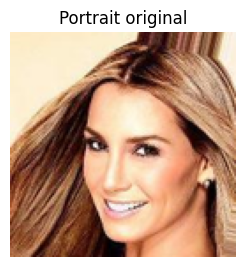

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

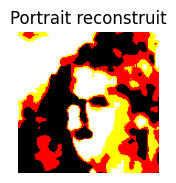

In [87]:
plt.subplot(1, 2, 1)
plt.title("Portrait original")
plt.imshow(image_originale[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 2)
plt.title("Portrait reconstruit")
plt.imshow(nouvelle_image[0])
plt.axis('off')